In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import time
from scipy.fft import fft, ifft
from scipy import interpolate

In [12]:
#added the files stored locally to the collab
mindwave_file = r"C:\Users\lavin\Downloads\MWData (1)\MW.txt"
muse_file = r"C:\Users\lavin\Downloads\MuseData\MU.txt"

#function to load the data from a file
#mentioned that \t was the seperator so spliting the data to sort into columns in dataframe subsequently
def load_data(file_path):
    data= []
    with open(file_path, 'r') as file:
        for line in file:
            line = line.split('\t')
            data.append(line)
    return data

# Load data from the files
mindwave_data = load_data(mindwave_file)
muse_data = load_data(muse_file)

#create dataframes
mindwave_df = pd.DataFrame(mindwave_data, columns=['id', 'event_id', 'device', 'channel', 'code', 'size', 'data'])
muse_df=pd.DataFrame(muse_data,columns=['id', 'event_id', 'device', 'channel', 'code', 'size', 'data'])

#getting FP1 and FP2 channels from muse
FP1_df =muse_df[muse_df['channel']=='FP1']
FP1_df.columns = ['id', 'event_id', 'device', 'channel', 'code', 'size', 'data']
FP2_df =muse_df[muse_df['channel']=='FP2']
FP1_df.columns = ['id', 'event_id', 'device', 'channel', 'code', 'size', 'data']

#new muse dataframe with FP1 and FP2
muse2_df = pd.concat([FP1_df, FP2_df]).reset_index(drop=True)
print(muse2_df)
mindwave_df.head()


            id event_id device channel code size  \
0       978112   132669     MU     FP1    6  459   
1       978116   132670     MU     FP1    7  493   
2       978120   132671     MU     FP1    6  459   
3       978124   132672     MU     FP1    6  459   
4       978128   132673     MU     FP1    1  493   
...        ...      ...    ...     ...  ...  ...   
81961  1142025   173647     MU     FP2   -1  460   
81962  1142029   173648     MU     FP2   -1  460   
81963  1142033   173649     MU     FP2   -1  460   
81964  1142037   173650     MU     FP2   -1  460   
81965  1142041   173651     MU     FP2   -1  460   

                                                    data  
0      468,487,493,493,498,493,491,490,492,487,483,48...  
1      505,515,513,506,512,520,512,521,517,512,517,52...  
2      502,516,514,508,514,520,520,524,513,514,518,51...  
3      512,529,527,526,522,522,525,530,523,523,531,52...  
4      506,511,513,518,505,522,526,509,517,514,514,51...  
...                  

,id,event_id,device,channel,code,size,data
0,0,0,MW,FP1,0,1017,"38,48,51,44,48,56,56,41,20,-3,-9,-1,6,5,6,17,2..."
1,1,1,MW,FP1,1,889,"83,74,65,65,66,55,43,25,18,20,26,33,41,38,28,3..."
2,2,2,MW,FP1,4,1017,"19,10,-2,-9,-5,3,8,7,8,2,-10,-21,-22,-27,-30,-..."
3,3,3,MW,FP1,1,1017,"17,29,36,26,21,17,17,13,17,21,25,26,20,5,-5,-1..."
4,4,4,MW,FP1,8,952,"77,74,69,70,76,75,76,75,67,66,76,93,98,82,55,3..."


In [14]:
# Combining the MindWave and Muse DataFrames

df = pd.concat([muse2_df,mindwave_df],axis=0).reset_index(drop=True)
df.info()
df['data'] = df['data'].apply(lambda x: np.array(x.split(',')))


#given median length =459 so resampling must be done to make size of all data equal to median length
median_length=459

df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149601 entries, 0 to 149600
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        149601 non-null  object
 1   event_id  149601 non-null  object
 2   device    149601 non-null  object
 3   channel   149601 non-null  object
 4   code      149601 non-null  object
 5   size      149601 non-null  object
 6   data      149601 non-null  object
dtypes: object(7)
memory usage: 8.0+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149601 entries, 0 to 149600
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        149601 non-null  object
 1   event_id  149601 non-null  object
 2   device    149601 non-null  object
 3   channel   149601 non-null  object
 4   code      149601 non-null  object
 5   size      149601 non-null  object
 6   data      149601 non-null  object
dtypes: object(7)
memory usage: 8.0+ M

,id,event_id,device,channel,code,size,data
0,978112,132669,MU,FP1,6,459,"[468, 487, 493, 493, 498, 493, 491, 490, 492, ..."
1,978116,132670,MU,FP1,7,493,"[505, 515, 513, 506, 512, 520, 512, 521, 517, ..."
2,978120,132671,MU,FP1,6,459,"[502, 516, 514, 508, 514, 520, 520, 524, 513, ..."
3,978124,132672,MU,FP1,6,459,"[512, 529, 527, 526, 522, 522, 525, 530, 523, ..."
4,978128,132673,MU,FP1,1,493,"[506, 511, 513, 518, 505, 522, 526, 509, 517, ..."
5,978132,132674,MU,FP1,6,459,"[508, 521, 535, 522, 525, 520, 521, 523, 517, ..."
6,978136,132675,MU,FP1,6,493,"[504, 508, 514, 514, 510, 513, 514, 519, 506, ..."
7,978140,132676,MU,FP1,8,442,"[511, 521, 514, 517, 524, 515, 515, 515, 518, ..."
8,978144,132677,MU,FP1,1,476,"[515, 523, 526, 527, 528, 522, 524, 526, 526, ..."
9,978148,132678,MU,FP1,9,493,"[510, 517, 526, 516, 512, 526, 521, 528, 526, ..."


In [15]:
#function to perform linear interpolation on a row and return as panda series

      #new indices:np.linspace(0, 1, median_length),old indices:np.linspace(0, 1, len(row))
def interpolate_row(row):
    return np.array(np.interp(np.linspace(0, 1, median_length), np.linspace(0, 1, len(row)), row))


In [16]:
df['data'] = df['data'].apply(lambda x: [float(i) for i in x])
interpolated_data = df['data'].apply(interpolate_row)

interpolated_data_array=interpolated_data.apply(lambda row : np.array(row))


print(interpolated_data_array)

interpolated_data_array.info()


0         [468.0, 487.0, 493.0, 493.0, 498.0, 493.0, 491...
1         [505.0, 514.8515283842795, 511.96069868995636,...
2         [502.0, 516.0, 514.0, 508.0, 514.0, 520.0, 520...
3         [512.0, 529.0, 527.0, 526.0, 522.0, 522.0, 525...
4         [506.0, 511.1484716157205, 513.7423580786026, ...
                                ...                        
149596    [138.0, 116.69213973799127, 49.18777292576419,...
149597    [4.0, -8.168122270742357, -13.803493449781659,...
149598    [96.0, 201.22489082969432, 121.99126637554585,...
149599    [-30.0, 60.47598253275109, 78.39301310043669, ...
149600    [41.0, 49.1768558951965, 84.26200873362446, 78...
Name: data, Length: 149601, dtype: object
<class 'pandas.core.series.Series'>
RangeIndex: 149601 entries, 0 to 149600
Series name: data
Non-Null Count   Dtype 
--------------   ----- 
149601 non-null  object
dtypes: object(1)
memory usage: 1.1+ MB


In [17]:
df["resampled_data"]=interpolated_data_array

# Check the length of the resampled arrays
df["resampled_data_length"] = df["resampled_data"].apply(len)

print(df)
#hence resampled lenght is the same

            id event_id device channel code  size  \
0       978112   132669     MU     FP1    6   459   
1       978116   132670     MU     FP1    7   493   
2       978120   132671     MU     FP1    6   459   
3       978124   132672     MU     FP1    6   459   
4       978128   132673     MU     FP1    1   493   
...        ...      ...    ...     ...  ...   ...   
149596   67630    67630     MW     FP1   -1  1024   
149597   67631    67631     MW     FP1   -1  1024   
149598   67632    67632     MW     FP1   -1  1024   
149599   67633    67633     MW     FP1   -1  1024   
149600   67634    67634     MW     FP1   -1  1024   

                                                     data  \
0       [468.0, 487.0, 493.0, 493.0, 498.0, 493.0, 491...   
1       [505.0, 515.0, 513.0, 506.0, 512.0, 520.0, 512...   
2       [502.0, 516.0, 514.0, 508.0, 514.0, 520.0, 520...   
3       [512.0, 529.0, 527.0, 526.0, 522.0, 522.0, 525...   
4       [506.0, 511.0, 513.0, 518.0, 505.0, 522.0, 526... 

In [19]:
 # Check if there are any duplicate index values
duplicates =df.index.duplicated()
print(duplicates.any()) 

False


In [20]:
data_array = np.array(df["resampled_data"].tolist())
codes = df['code'].tolist()


In [22]:
srate = 220
def time_frequency(data, cmwX, nKern):
    ''''
    Function to calculate time-frequency representation of multichannel data.

    Parameters:
    data : ndarray
        The EEG data, array of shape (channels, time).
    cmwX : ndarray
        The Fourier coefficients of the complex Morlet wavelets, array of shape (frequencies, nConv).
    nKern : int
        The length of the wavelet kernel.
    channel_labels : list, optional
        The labels of the EEG channels. Must be the same length as the number of channels in the data.
        If not provided, no channel labels will be used.

    Returns:
    tf : ndarray
        The time-frequency representation of the data, array of shape (frequencies, time).
        This is the average power across all channels.
    '''

    # set up convolution parameters
    nData   = data.shape[1]
    nConv   = nData + nKern - 1
    halfwav = (nKern-1)//2

    # initialize time-frequency output matrix
    tf = np.zeros((data.shape[0], cmwX.shape[0], data.shape[1])) # channels X frequency X times

    # loop over channels
    for chani in range(data.shape[0]):

        # compute Fourier coefficients of EEG data
        eegX = fft(data[chani, :] , nConv)

        # perform convolution and extract power (vectorized across frequencies)
        as_ = ifft(cmwX * eegX[None, :], axis=1)
        as_ = as_[:, halfwav: -halfwav]
        tf[chani, :, :] = np.abs(as_) ** 2

    return tf


def get_cmwX(nData, freqrange=[1,40], numfrex=42):
    '''
    Function to calculate the Fourier coefficients of complex Morlet wavelets.

    Parameters:
    nData : int
        The number of data points.
    freqrange : list, optional
        The range of frequencies to consider. Defaults to [1,40].
    numfrex : int, optional
        The number of frequencies between the lowest and highest frequency. Defaults to 42.

    Returns:
    cmwX : ndarray
        The Fourier coefficients of the complex Morlet wavelets, array of shape (frequencies, nConv).
    nKern : int
        The length of the wavelet kernel.
    frex : ndarray
        The array of frequencies.
    '''
    pi = np.pi
    wavtime = np.arange(-2,2-1/srate,1/srate)
    nKern = len(wavtime)
    nConv = nData + nKern - 1
    frex = np.linspace(freqrange[0],freqrange[1],numfrex)
   # create complex morlet wavelets array
    cmwX = np.zeros((numfrex, nConv), dtype=complex)

    # number of cycles
    numcyc = np.linspace(3,15,numfrex);
    for fi in range(numfrex):
        # create time-domain wavelet
        s = numcyc[fi] / (2*pi*frex[fi])
        twoSsquared = (2*s) ** 2
        cmw = np.exp(2*1j*pi*frex[fi]*wavtime) * np.exp( (-wavtime**2) / twoSsquared )


        # compute fourier coefficients of wavelet and normalize
        cmwX[fi, :] = fft(cmw, nConv)
        cmwX[fi, :] = cmwX[fi, :] / max(cmwX[fi, :])

    return cmwX, nKern, frex

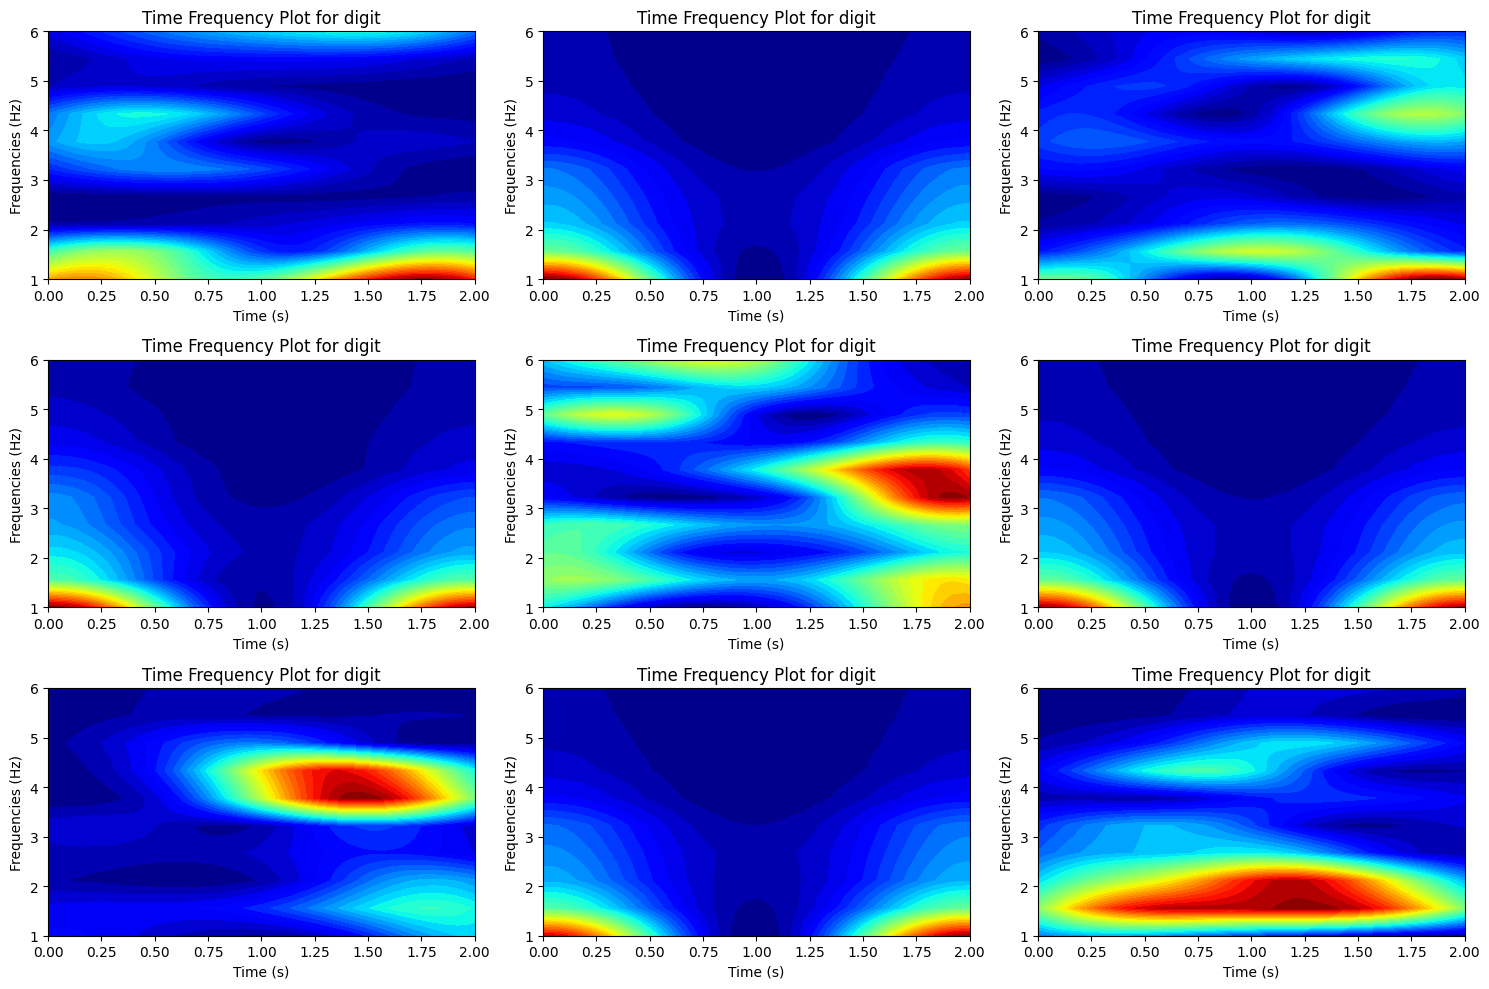

In [23]:
starting_freq = 1
end_freq = 6
num_frequencies = 10

#  Creates an array of time values starting from 0 to 2 seconds, with a total number of elements defined by median_length.
times = np.linspace(0,2,median_length)

nData = data_array.shape[1]
cmwX, nKern, frex = get_cmwX(nData, freqrange=[starting_freq, end_freq], numfrex=num_frequencies)
tf = time_frequency(data_array, cmwX, nKern)

fig, axs = plt.subplots(3, 3, figsize=(15, 10))

for i,ax in enumerate(axs.flat):
  x = random.randint(0, tf.shape[0])
  contour = ax.contourf(times, frex, tf[x,:,:], 40, cmap='jet')
  ax.set_xlabel('Time (s)')
  ax.set_ylabel('Frequencies (Hz)')
  ax.set_title(f"Time Frequency Plot for {'non-digit' if codes[x] == -1 else 'digit'}")

fig.tight_layout()